In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

## Data Cleaning and Preparation

In [2]:
# reading in data and getting the info on each column
diabetes = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [3]:
# because the values above are floats, this converts all columns to int
diabetes = diabetes.astype(int)

In [4]:
# converting "prediabetes" individuals to "no diabetes"
diabetes['Diabetes_012'] = diabetes['Diabetes_012'].replace(1, 0)

# converting the diabetes label from 2 to 1 
diabetes['Diabetes_012'] = diabetes['Diabetes_012'].replace(2, 1)

diabetes["Diabetes_012"]

0         0
1         0
2         0
3         0
4         0
         ..
253675    0
253676    1
253677    0
253678    0
253679    1
Name: Diabetes_012, Length: 253680, dtype: int64

In [5]:
# checking number of values for each
uniq = diabetes['Diabetes_012'].value_counts()

print(uniq)

0    218334
1     35346
Name: Diabetes_012, dtype: int64


In [6]:
# evening the data so that there are an equal number of 0 values as 1 values for the diabetes column
num_ones = (diabetes['Diabetes_012'] == 1).sum()

# separate no diabetes users
no_diabetes = diabetes[diabetes['Diabetes_012'] == 0].sample(n=num_ones, random_state=42)
uniq_no = no_diabetes['Diabetes_012'].value_counts()
print(uniq_no)

0    35346
Name: Diabetes_012, dtype: int64


In [7]:
# Separate users into diabetes and no diabetes groups
diabetes_users = diabetes[diabetes['Diabetes_012'] == 1]

# limit to a lower number (to reduce computation)
n=500
no_diabetes = no_diabetes.sample(n=n, random_state=42)
diabetes_users = diabetes_users.sample(n=n, random_state=42)

diabetes_balanced = pd.concat([no_diabetes, diabetes_users])

# Save the balanced dataset to CSV
diabetes_balanced.to_csv('balanced_diabetes_data.csv', index=False)

diabetes_balanced = diabetes_balanced.reset_index(drop=True)

In [8]:
print(diabetes_balanced['Diabetes_012'].value_counts())
print(len(diabetes_balanced))

0    500
1    500
Name: Diabetes_012, dtype: int64
1000


## Data Cleaning and Preparation (diff dataset)

In [9]:
df_balanced = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
df_balanced.head()

df_balanced = df_balanced.astype(int)

In [10]:
print(df_balanced['Diabetes_binary'].value_counts())

# Set desired number of samples per class
n_samples = 500

# Sample 500 instances from each class
df_balanced = (
    df_balanced
    .groupby('Diabetes_binary', group_keys=False)
    .apply(lambda x: x.sample(n=n_samples, random_state=42))
    .reset_index(drop=True)
)

# Check the new distribution
print(df_balanced['Diabetes_binary'].value_counts())

0    35346
1    35346
Name: Diabetes_binary, dtype: int64
0    500
1    500
Name: Diabetes_binary, dtype: int64


## KNN + Collaborative Filtering

**Using 2 classes - diabetes and no diabetes**

In [27]:
df = pd.read_csv('balanced_diabetes_data.csv')

# Separate features and labels
X = df.drop(columns=['Diabetes_012']).reset_index(drop=True)
y = df['Diabetes_012'].reset_index(drop=True)

# Step 1: Use KNN (Euclidean) to find similar users for each user
n_neighbors = 11  # 10 nearest neighbors + self
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn.fit(X)
_, indices = knn.kneighbors(X)

# Step 2: For each user, find most similar other user in cluster using cosine similarity
misdiagnosed_set = set()

for i in range(len(X)):
    user_idx = i
    cluster_indices = indices[i][1:]  # exclude self

    target_user = X.iloc[user_idx].values.reshape(1, -1)
    cluster_users = X.iloc[cluster_indices].values

    # Step 3: Compute cosine similarity
    sim_scores = cosine_similarity(target_user, cluster_users).flatten()

    # Get the index (in cluster_indices) of the most similar user
    most_similar_relative_idx = np.argmax(sim_scores)
    most_similar_idx = cluster_indices[most_similar_relative_idx]

    # Step 4: Predict based on most similar user's diagnosis
    predicted = y.iloc[most_similar_idx]
    actual = y.iloc[user_idx]

    if predicted != actual:
        misdiagnosed_set.add(user_idx)

# Step 5: Get distinct misdiagnosed users
misdiagnosed_df = df.iloc[list(misdiagnosed_set)]

print(f"Number of potential misdiagnosed users: {len(misdiagnosed_df)}")

# Save results
misdiagnosed_df.to_csv("misdiagnosed_cases_cosine_hybrid.csv", index=False)

Number of potential misdiagnosed users: 321


## KNN + Collaborative Filtering

**Using balanced df with 3 classes - diabetes, no diabetes, prediabetes**

In [26]:
X = df_balanced.drop(columns=['Diabetes_binary']).reset_index(drop=True)
y = df_balanced['Diabetes_binary'].reset_index(drop=True)

# Step 1: Use KNN (Euclidean) to find similar users for each user
n_neighbors = 11  # 10 nearest neighbors + self
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn.fit(X)
_, indices = knn.kneighbors(X)

# Step 2: For each user, find the most similar user using cosine similarity
misdiagnosed_set = set()

for i in range(len(X)):
    user_idx = i
    cluster_indices = indices[i][1:]  # exclude self

    target_user = X.iloc[user_idx].values.reshape(1, -1)
    cluster_users = X.iloc[cluster_indices].values

    # Step 3: Compute cosine similarity
    sim_scores = cosine_similarity(target_user, cluster_users).flatten()

    # Get index (in cluster_indices) of most similar user
    most_similar_relative_idx = np.argmax(sim_scores)
    most_similar_idx = cluster_indices[most_similar_relative_idx]
    max_similarity = sim_scores[most_similar_relative_idx]

    # Step 4: Only proceed if similarity is above threshold
    n = 0.99
    if max_similarity > n:
        predicted = y.iloc[most_similar_idx]
        actual = y.iloc[user_idx]

        if predicted != actual:
            misdiagnosed_set.add(user_idx)

# Step 5: Get distinct misdiagnosed users
misdiagnosed_df = df_balanced.iloc[list(misdiagnosed_set)]

print("Number of potential misdiagnosed users (cosine similarity > ", n, "): ", len(misdiagnosed_df))

Number of potential misdiagnosed users (cosine similarity >  0.99 ):  298


**Plot of Clusters**

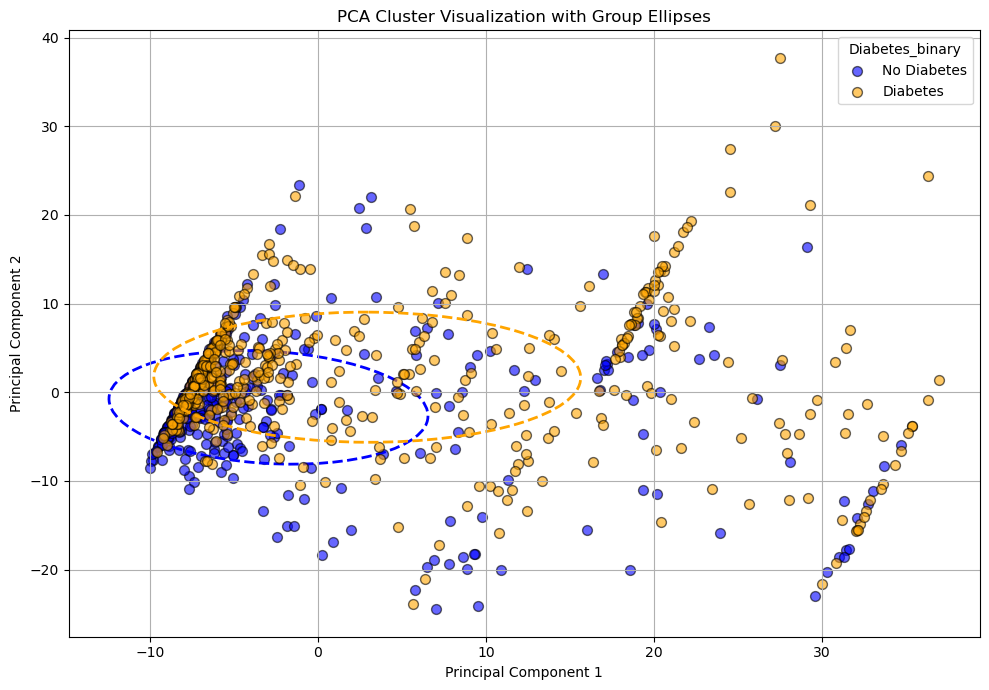

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import numpy as np

# Prepare data
X = df_balanced.drop(columns=['Diabetes_binary'])
y = df_balanced['Diabetes_binary']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Define colors and labels
colors = {0: 'blue', 1: 'orange'}
labels = {0: 'No Diabetes', 1: 'Diabetes'}

plt.figure(figsize=(10, 7))

# Plot each class with scatter and ellipse
for class_value in sorted(y.unique()):
    idx = y == class_value
    X_class = X_2d[idx]

    # Scatter plot
    plt.scatter(X_class[:, 0], X_class[:, 1], c=colors[class_value], label=labels[class_value], s=50, alpha=0.6, edgecolor='k')

    # Calculate ellipse parameters
    mean = X_class.mean(axis=0)
    cov = np.cov(X_class, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Angle of ellipse in degrees
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # Width and height are 2 standard deviations
    width, height = 2 * np.sqrt(eigenvalues)

    # Draw ellipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=colors[class_value], fc='none', lw=2, linestyle='--')
    plt.gca().add_patch(ellipse)

# Plot decorations
plt.title("PCA Cluster Visualization with Group Ellipses")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Diabetes_binary")
plt.grid(True)
plt.tight_layout()
plt.show()

## KNN + Collaborative Filtering

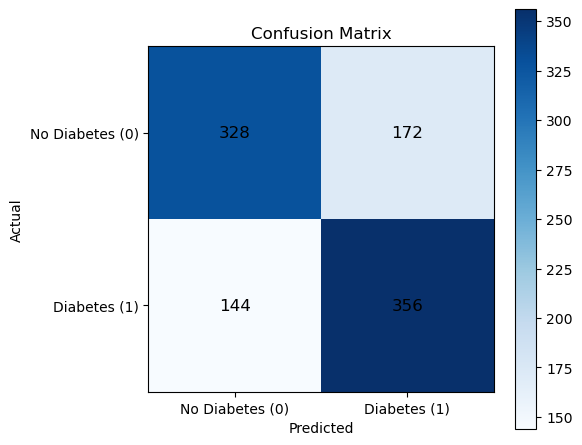

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report

# Step 0: Prepare features and labels
X = df_balanced.drop(columns=['Diabetes_binary']).reset_index(drop=True)
y = df_balanced['Diabetes_binary'].reset_index(drop=True)

# Step 1: Use KNN (Euclidean) to find similar users for each user
n_neighbors = 11
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn.fit(X)
_, indices = knn.kneighbors(X)

# Step 2: Predict based on most similar user (cosine sim > 0.95)
y_pred = []
y_true = []

for i in range(len(X)):
    user_idx = i
    cluster_indices = indices[i][1:]

    target_user = X.iloc[user_idx].values.reshape(1, -1)
    cluster_users = X.iloc[cluster_indices].values

    sim_scores = cosine_similarity(target_user, cluster_users).flatten()
    most_similar_relative_idx = np.argmax(sim_scores)
    most_similar_idx = cluster_indices[most_similar_relative_idx]
    max_similarity = sim_scores[most_similar_relative_idx]

    if max_similarity > 0.95:
        predicted = y.iloc[most_similar_idx]
        actual = y.iloc[user_idx]
        y_pred.append(predicted)
        y_true.append(actual)

# Step 3: Create confusion matrix
labels = [0, 1]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Step 4: Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

# Show all ticks and label them
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])
ax.set_yticklabels(['No Diabetes (0)', 'Diabetes (1)'])

# Label axes
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Loop over data dimensions and create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

plt.colorbar(im)
plt.tight_layout()
plt.show()